In [122]:
from sklearn.naive_bayes import MultinomialNB
from audioop import cross
from contextlib import redirect_stdout
from sklearn.model_selection import StratifiedKFold
from mealpy.swarm_based import AO, HGS, SSA, MRFO, HHO
from matplotlib import pyplot
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, auc
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std

DEFAULT_PARAMS = [0.0001, 0.1, 1e-3]

EN = pd.read_csv(f'./input/enron/messages.csv').fillna(' ')
X_EN = np.array(EN['message'])
y_EN = np.array(EN['label'])

LS = pd.read_csv(f'./input/ling_spam/messages.csv').fillna(' ')
X_LS = np.array(LS['message'])
y_LS = np.array(LS['label'])

SA = pd.read_csv(f'./input/spam_assasin/messages.csv').fillna(' ')
X_SA = np.array(SA['message'])
y_SA = np.array(SA['label'])

In [123]:
def resolve_dataset(name):
    if (name == 'EN'):
        return [X_EN.copy(), y_EN.copy()]
    elif (name == 'LS'):
        return [X_LS.copy(), y_LS.copy()]
    elif (name == 'SA'):
        return [X_SA.copy(), y_SA.copy()]
    else:
        return


def resolve_alg(alg):
    if alg == 'AO':
        return AO.OriginalAO
    elif alg == 'HGS':
        return HGS.OriginalHGS
    elif alg == 'SSA':
        return SSA.OriginalSSA
    elif alg == 'MRFO':
        return MRFO.BaseMRFO
    
def alg_to_label(alg):
    if alg == 'AO':
        return 'Оптимизатор орла (AO)'
    elif alg == 'HGS':
        return 'Поиск голодных игр (HGS)'
    elif alg == 'SSA':
        return 'Алгоритм поиска воробьев (SSA)'
    elif alg == 'MRFO':
        return 'Алгоритм кормодобывания \nскатов манта (MRFO)'
    elif alg == 'RSCV':
        return 'Случайный поиск'
    elif alg == 'DEFAULT':
        return 'Параметры по умолчанию'


def test(clfs, train, test):
    print(f'Test models trained with {train} on {test}')

    for alg in clfs:
        X, y = resolve_dataset(test)
        clf = clfs[alg]

        y_score = clf.decision_function(X)
        y_pred = clf.predict(X)

        print(alg)
        print('Accuracy %.5f: ' % accuracy_score(y, y_pred))
        print('ROC: %.5f' % roc_auc_score(y, y_score))
        print('F1: %.5f\n' % f1_score(y, y_pred))
        
#         precision, recall, _ = precision_recall_curve(y,y_score)
#         print('AUC Precision Recall: %.5f' % pr_auc)
#         pyplot.plot(recall, precision, marker=',', label=alg_to_label(alg))

        y_fpr, y_tpr, _ = roc_curve(y, y_score)
        pyplot.plot(y_fpr, y_tpr, marker=',', label=alg_to_label(alg) + ', ROC: %.5f' % roc_auc_score(y, y_score))
    
#     no_skill = len(y[y==1]) / len(y)
#     pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Без навыков')
#     pyplot.xlabel('Recall')
#     pyplot.ylabel('Precision')

    ns_probs = [0 for _ in range(len(y))]
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Без навыков')
    pyplot.xlabel('Ошибка первого рода')
    pyplot.ylabel('Чувствительность')
    pyplot.legend()
    pyplot.show()

In [124]:
pyplot.rcParams['figure.figsize'] = [30, 15]
pyplot.rcParams.update({'font.size': 30})

In [125]:
best_LS_RSCV = [0.001, 1, 1]
best_LS_MRFO = [0.00011623717756157859, 484.27076763414436, 216.5086989934]
best_LS_HGS = [0.0022917872068965736, 19.823049434350512, 90.57441814602444]
best_LS_AO = [0.19002423039394772, 41.07346210476601, 57.552068978376624]
best_LS_SSA = [0.032970495018666765, 183.32506925145373, 117.76141405995111]

best_SA_RSCV = [0.0001, 1, 10]
best_SA_MRFO = [0.00010870235001272333, 451.9050393554245, 181.09353850833924]
best_SA_HGS = [0.00011032170757958722, 0.00011472906393677556, 2.7412975859147672]
best_SA_AO = [0.0001, 0.1882828225532926, 0.06256962757736609]
best_SA_SSA = [0.00010541550010794703, 171.5336819945209, 170.657590549754]

best_EN_RSCV = [0.0001, 1, 10]
best_EN_MRFO = [0.00010110580912339215, 339.20447492054046, 377.83845464774805]
best_EN_HGS = [0.00010085619945834547, 154.9162953216401, 116.10455211284992]
best_EN_AO = [0.0001, 96.33289509195406, 111.70127122768649]
best_EN_SSA = [0.0001, 109.01548465909111, 97.49608032123167]

In [134]:
LS_EN = {1.: 10, 0.: 1}
LS_SA = {1.: 1, 0.: 1.5}

SA_EN = {1.: 10, 0.:1}
SA_LS = {1.: 1, 0.: 8}

EN_LS = {1.: 1, 0.: 100}
EN_SA = {1.: 1, 0.: 100}
    
def create_clf(params, class_weight=None):
    alpha, epsilon, tol = params
    return Pipeline([
        ('tfidf_vectorizer', TfidfVectorizer(
            stop_words=stopwords.words('english'))),
        ('clf', SGDClassifier(random_state=0,
         alpha=alpha, epsilon=epsilon, tol=tol, class_weight=class_weight, n_jobs=-1))
    ])

In [90]:
X, y = X_SA, y_SA

SA_clfs = {
    "RSCV": create_clf(best_SA_RSCV),
    "DEFAULT": create_clf(DEFAULT_PARAMS),
    "MRFO": create_clf(best_SA_MRFO),
    "HGS": create_clf(best_SA_HGS),
    "AO": create_clf(best_SA_AO),
    "SSA": create_clf(best_SA_SSA)
}

for alg in SA_clfs:
    print(alg, mean(cross_val_score(
        SA_clfs[alg], X, y, cv=10, scoring='accuracy')))

RSCV 0.9919826652221021
DEFAULT 0.9919826652221021
MRFO 0.9917659804983749
HGS 0.9920910075839655
AO 0.9919826652221021
SSA 0.9919826652221021


Test models trained with SA on EN
RSCV
Accuracy 0.74587: 
ROC: 0.82781
F1: 0.75221

DEFAULT
Accuracy 0.73768: 
ROC: 0.81607
F1: 0.73192

MRFO
Accuracy 0.72852: 
ROC: 0.81823
F1: 0.74758

HGS
Accuracy 0.74901: 
ROC: 0.83473
F1: 0.76391

AO
Accuracy 0.74655: 
ROC: 0.82737
F1: 0.75008

SSA
Accuracy 0.73086: 
ROC: 0.82057
F1: 0.75209



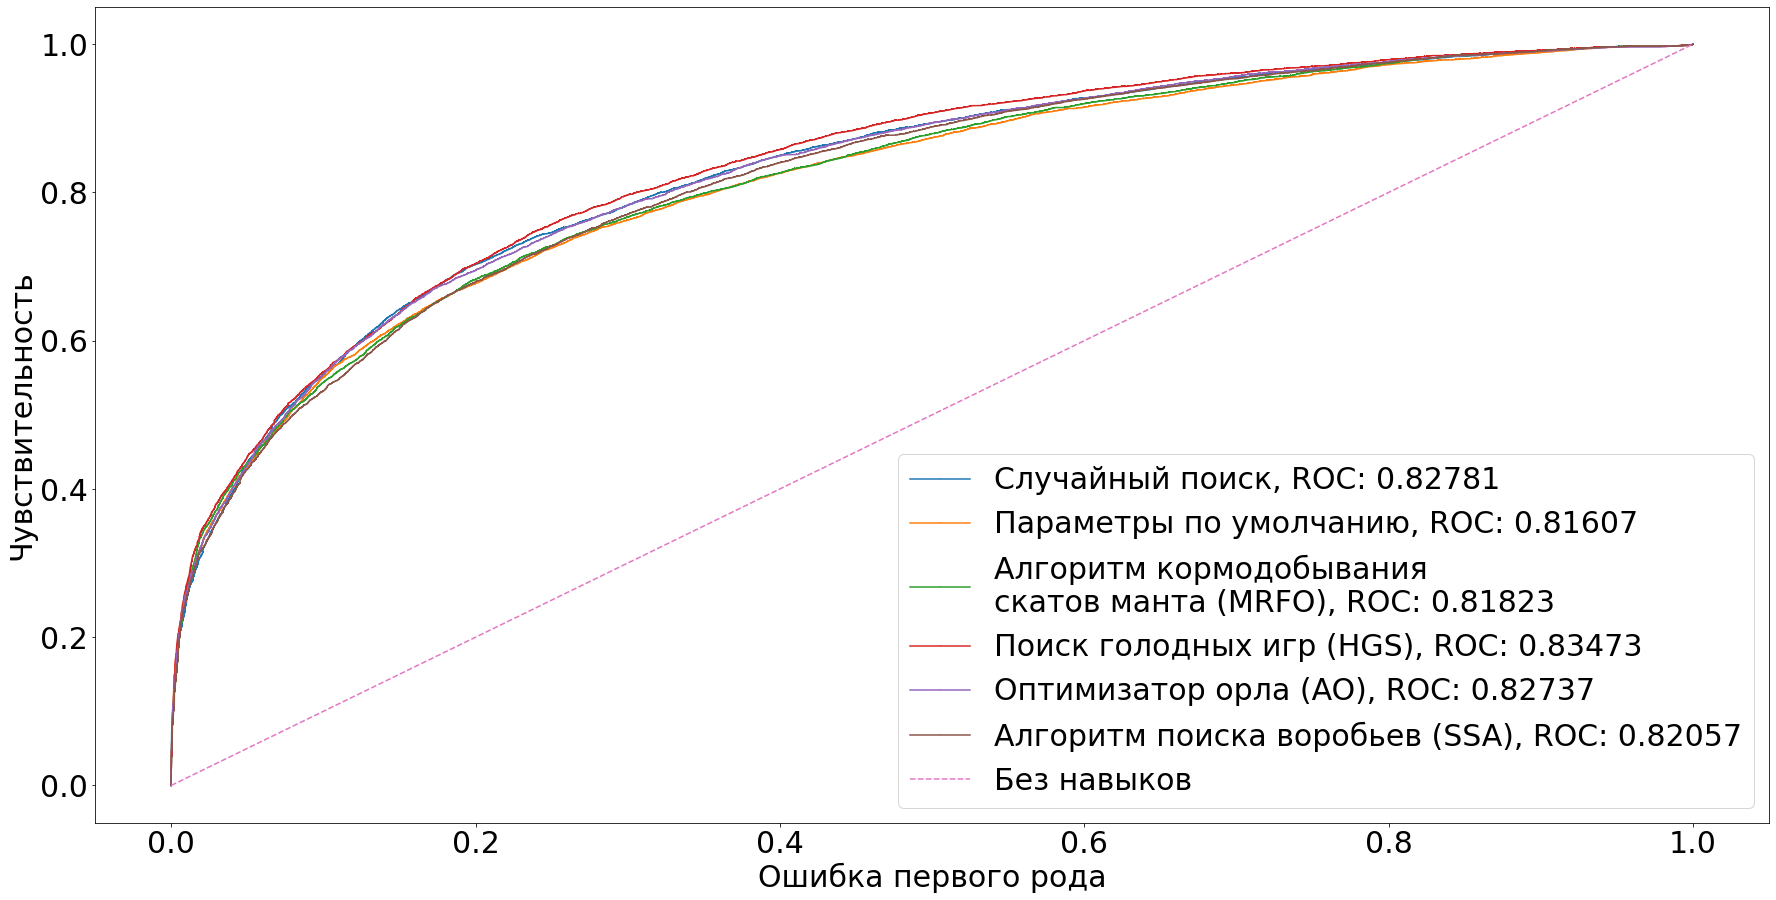

In [113]:
SA_EN_clfs = {
    "RSCV": create_clf(best_SA_RSCV, SA_EN),
    "DEFAULT": create_clf(DEFAULT_PARAMS, SA_EN),
    "MRFO": create_clf(best_SA_MRFO, SA_EN),
    "HGS": create_clf(best_SA_HGS, SA_EN),
    "AO": create_clf(best_SA_AO, SA_EN),
    "SSA": create_clf(best_SA_SSA, SA_EN)
}

for alg in SA_EN_clfs:
    SA_EN_clfs[alg].fit(X_SA, y_SA)

test(SA_EN_clfs, "SA", "EN")

Test models trained with SA on LS
RSCV
Accuracy 0.94469: 
ROC: 0.95560
F1: 0.83051

DEFAULT
Accuracy 0.94469: 
ROC: 0.96183
F1: 0.83193

MRFO
Accuracy 0.94988: 
ROC: 0.96412
F1: 0.83978

HGS
Accuracy 0.95092: 
ROC: 0.96414
F1: 0.84361

AO
Accuracy 0.95022: 
ROC: 0.96028
F1: 0.84382

SSA
Accuracy 0.95299: 
ROC: 0.96525
F1: 0.85055



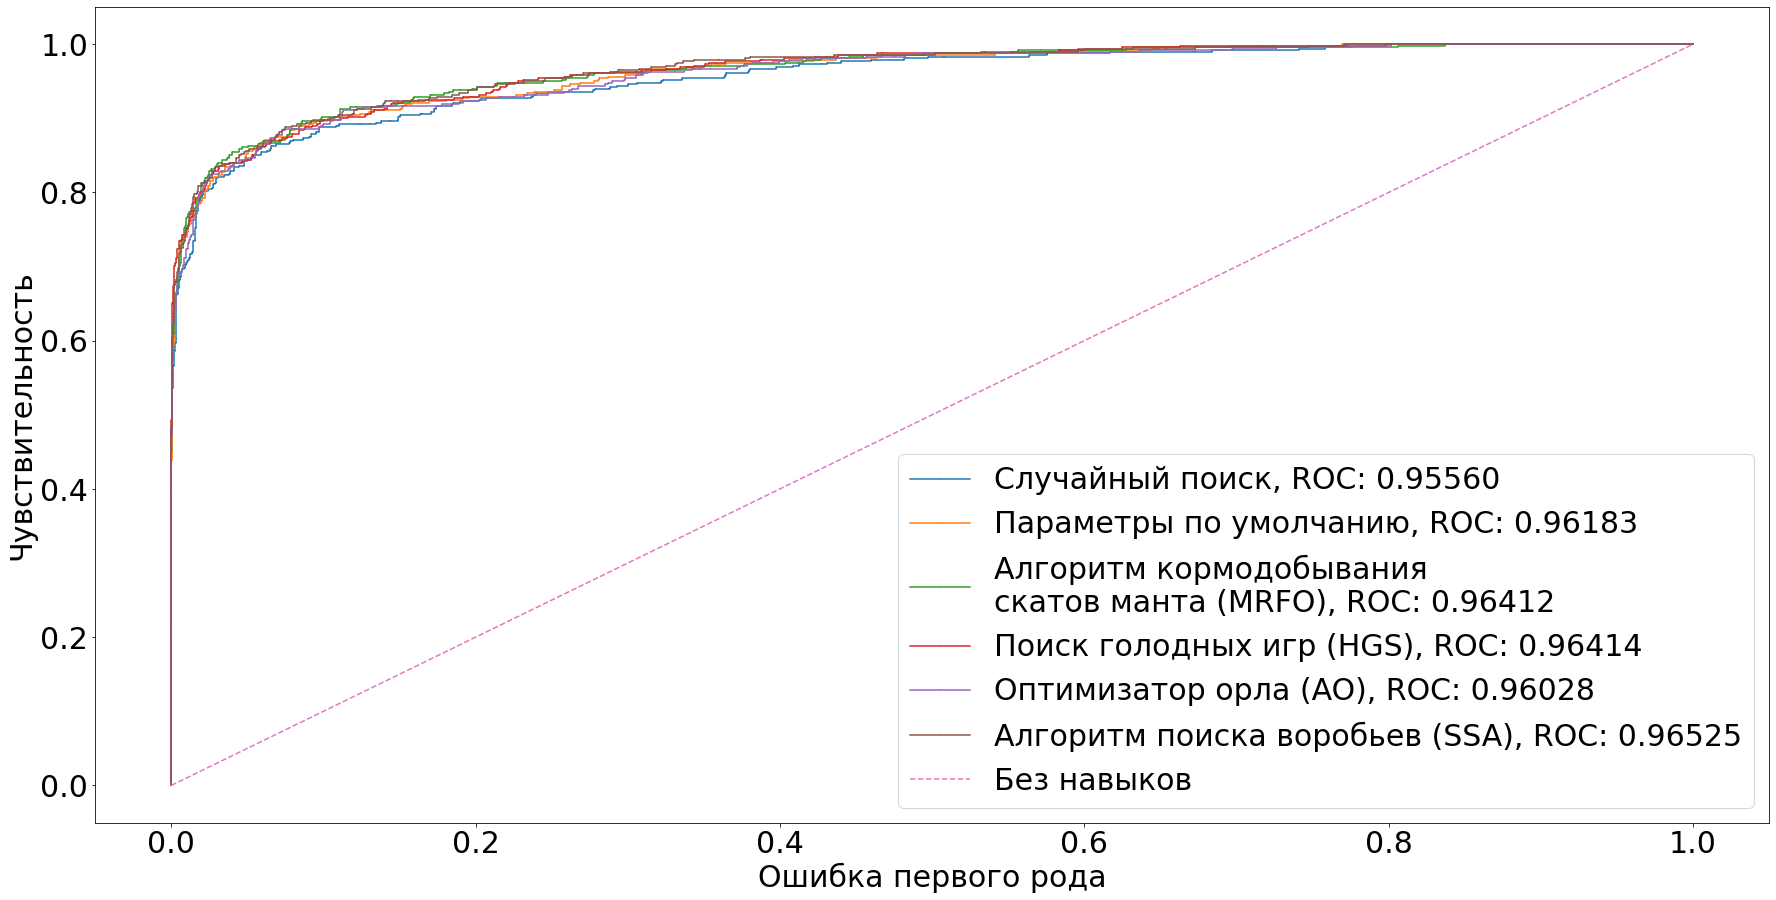

In [114]:
SA_LS_clfs = {
    "RSCV": create_clf(best_SA_RSCV, SA_LS),
    "DEFAULT": create_clf(DEFAULT_PARAMS, SA_LS),
    "MRFO": create_clf(best_SA_MRFO, SA_LS),
    "HGS": create_clf(best_SA_HGS, SA_LS),
    "AO": create_clf(best_SA_AO, SA_LS),
    "SSA": create_clf(best_SA_SSA, SA_LS)
}

for alg in SA_LS_clfs:
    SA_LS_clfs[alg].fit(X_SA, y_SA)

test(SA_LS_clfs, "SA", "LS")

In [133]:
X, y = X_LS, y_LS

LS_clfs = {
    "RSCV": create_clf(best_LS_RSCV),
    "DEFAULT": create_clf(DEFAULT_PARAMS),
    "MRFO": create_clf(best_LS_MRFO),
    "HGS": create_clf(best_LS_HGS),
    "AO": create_clf(best_LS_AO),
    "SSA": create_clf(best_LS_SSA)
}

for alg in LS_clfs:
    print(alg, mean(cross_val_score(
        LS_clfs[alg], X, y, cv=10, scoring='accuracy')))

RSCV 0.9875563775205822
DEFAULT 0.9934291850614485
MRFO 0.9934291850614484
HGS 0.9723493616513542
AO 0.8337370242214532
SSA 0.8337370242214532


Test models trained with LS on EN
RSCV
Accuracy 0.76183: 
ROC: 0.83161
F1: 0.75769

DEFAULT
Accuracy 0.70343: 
ROC: 0.81441
F1: 0.75167

MRFO
Accuracy 0.70675: 
ROC: 0.81793
F1: 0.75174

HGS
Accuracy 0.76482: 
ROC: 0.83227
F1: 0.76456

AO
Accuracy 0.50927: 
ROC: 0.73094
F1: 0.67486

SSA
Accuracy 0.50915: 
ROC: 0.80999
F1: 0.67471



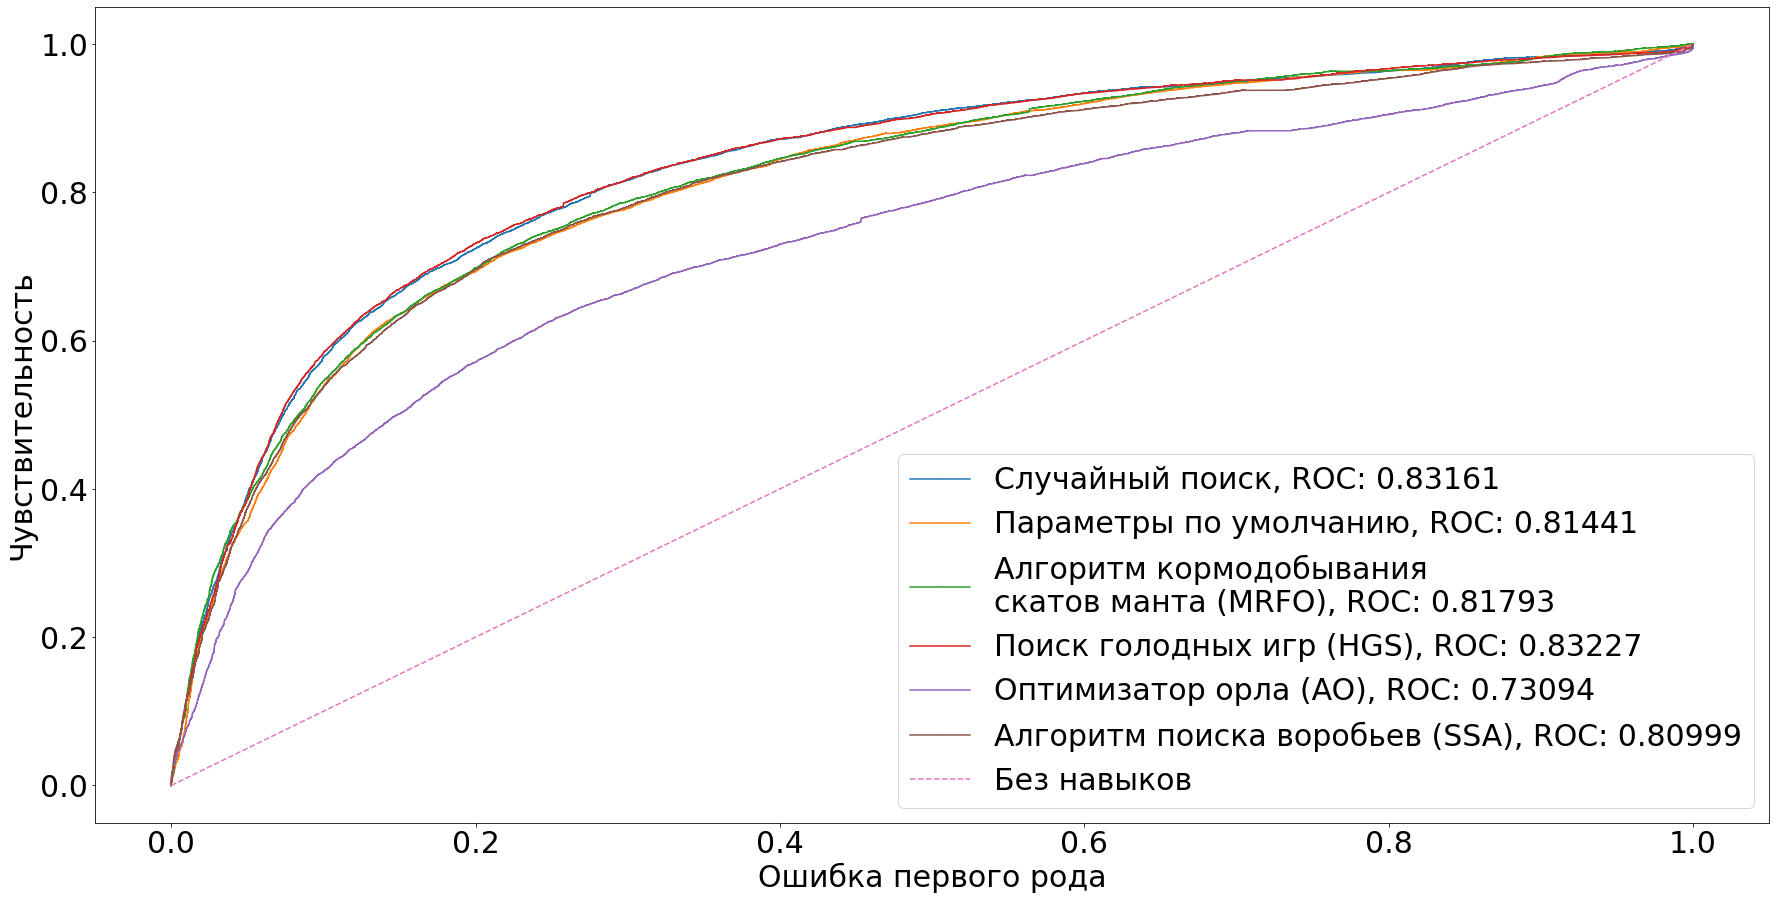

In [116]:
LS_EN_clfs = {
    "RSCV": create_clf(best_LS_RSCV, LS_EN),
    "DEFAULT": create_clf(DEFAULT_PARAMS, LS_EN),
    "MRFO": create_clf(best_LS_MRFO, LS_EN),
    "HGS": create_clf(best_LS_HGS, LS_EN),
    "AO": create_clf(best_LS_AO, LS_EN),
    "SSA": create_clf(best_LS_SSA, LS_EN)
}

for alg in LS_EN_clfs:
    LS_EN_clfs[alg].fit(X_LS, y_LS)

test(LS_EN_clfs, "LS", "EN")

Test models trained with LS on SA
HGS
Accuracy 0.89480: 
ROC: 0.92984
F1: 0.76438

DEFAULT
Accuracy 0.88711: 
ROC: 0.93652
F1: 0.79537

RSCV
Accuracy 0.90217: 
ROC: 0.93595
F1: 0.80551

MRFO
Accuracy 0.88082: 
ROC: 0.93655
F1: 0.78641

AO
Accuracy 0.75287: 
ROC: 0.70004
F1: 0.00000

SSA
Accuracy 0.75287: 
ROC: 0.93462
F1: 0.00000



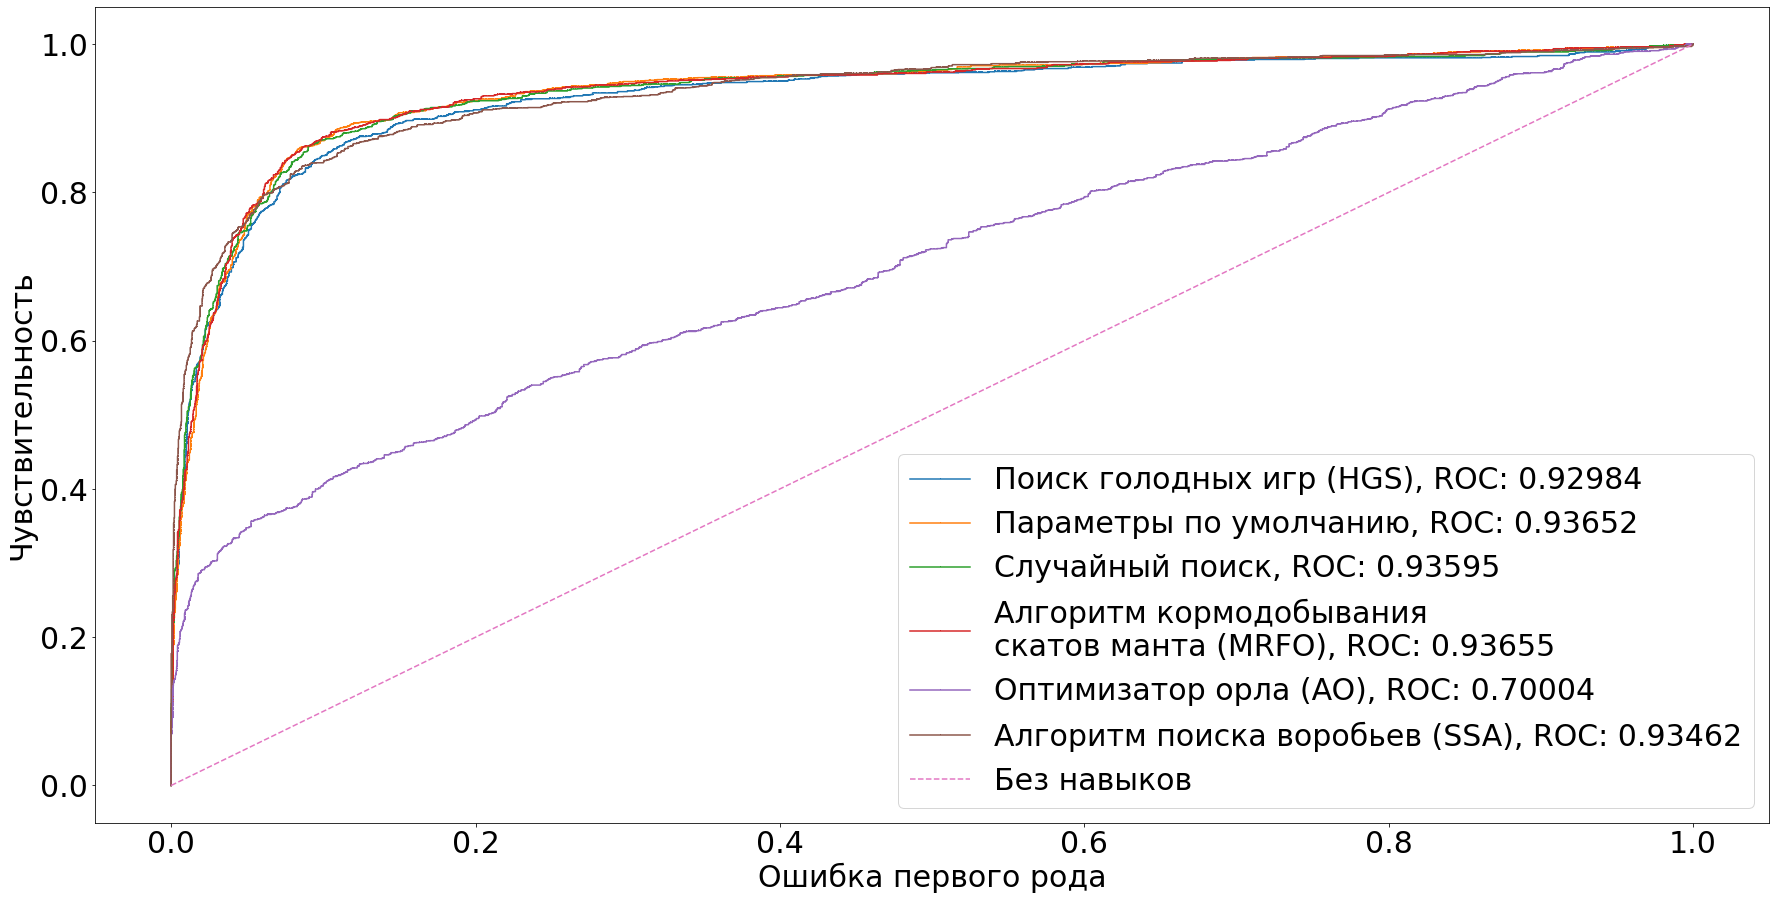

In [117]:
LS_SA = {1.: 1, 0.: 1}

LS_SA_clfs = {
    "HGS": create_clf(best_LS_HGS, LS_SA),
    "DEFAULT": create_clf(DEFAULT_PARAMS, LS_SA),
    "RSCV": create_clf(best_LS_RSCV, LS_SA),
    "MRFO": create_clf(best_LS_MRFO, LS_SA),
    "AO": create_clf(best_LS_AO, LS_SA),
    "SSA": create_clf(best_LS_SSA, LS_SA)
}

for alg in LS_SA_clfs:
    LS_SA_clfs[alg].fit(X_LS, y_LS)

test(LS_SA_clfs, "LS", "SA")

Test models trained with EN on LS
HGS
Accuracy 0.91116: 
ROC: 0.91323
F1: 0.74377

DEFAULT
Accuracy 0.81645: 
ROC: 0.92560
F1: 0.61826

RSCV
Accuracy 0.89803: 
ROC: 0.92651
F1: 0.72710

MRFO
Accuracy 0.90840: 
ROC: 0.91209
F1: 0.72821

AO
Accuracy 0.89803: 
ROC: 0.92651
F1: 0.72710

SSA
Accuracy 0.89803: 
ROC: 0.92651
F1: 0.72710



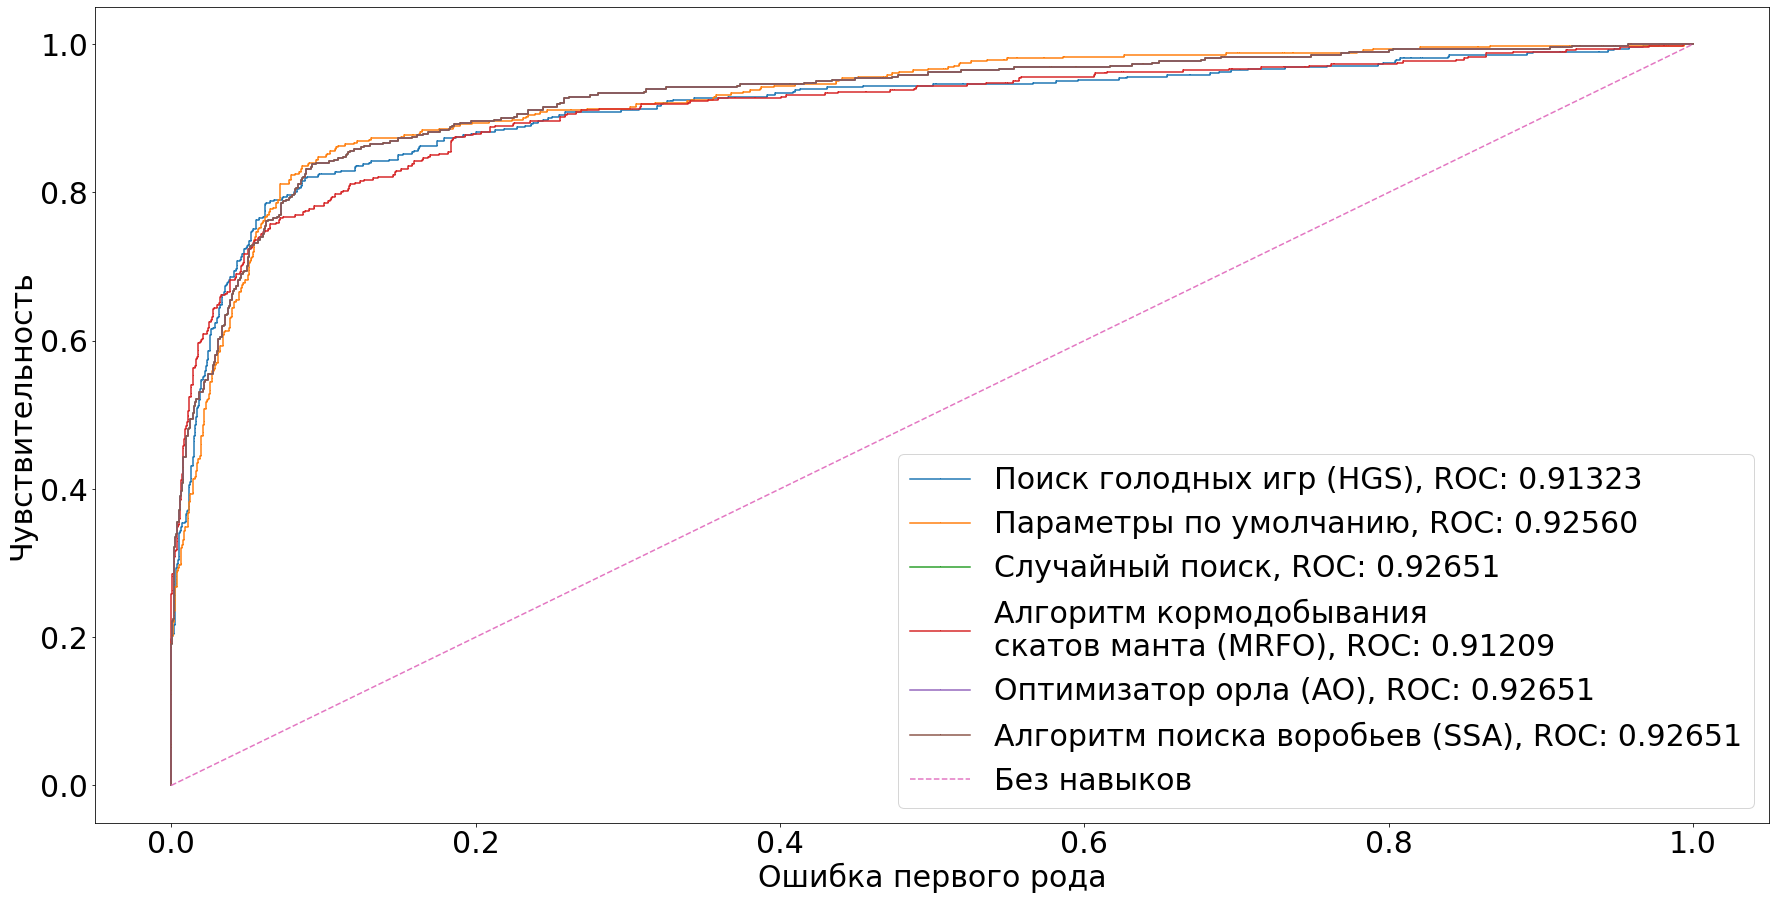

In [118]:

EN_LS = {1.: 1, 0.: 120}

EN_LS_clfs = {
    "HGS": create_clf(best_EN_HGS, EN_LS),
    "DEFAULT": create_clf(DEFAULT_PARAMS, EN_LS),
    "RSCV": create_clf(best_EN_RSCV, EN_LS),
    "MRFO": create_clf(best_EN_MRFO, EN_LS),
    "AO": create_clf(best_EN_AO, EN_LS),
    "SSA": create_clf(best_EN_SSA, EN_LS)
}

for alg in EN_LS_clfs:
    EN_LS_clfs[alg].fit(X_EN, y_EN)

test(EN_LS_clfs, "EN", "LS")

Test models trained with EN on SA
HGS
Accuracy 0.87963: 
ROC: 0.94258
F1: 0.77926

DEFAULT
Accuracy 0.77302: 
ROC: 0.96001
F1: 0.67734

RSCV
Accuracy 0.86880: 
ROC: 0.94526
F1: 0.76964

MRFO
Accuracy 0.89664: 
ROC: 0.95309
F1: 0.80562

AO
Accuracy 0.86880: 
ROC: 0.94526
F1: 0.76964

SSA
Accuracy 0.86880: 
ROC: 0.94526
F1: 0.76964



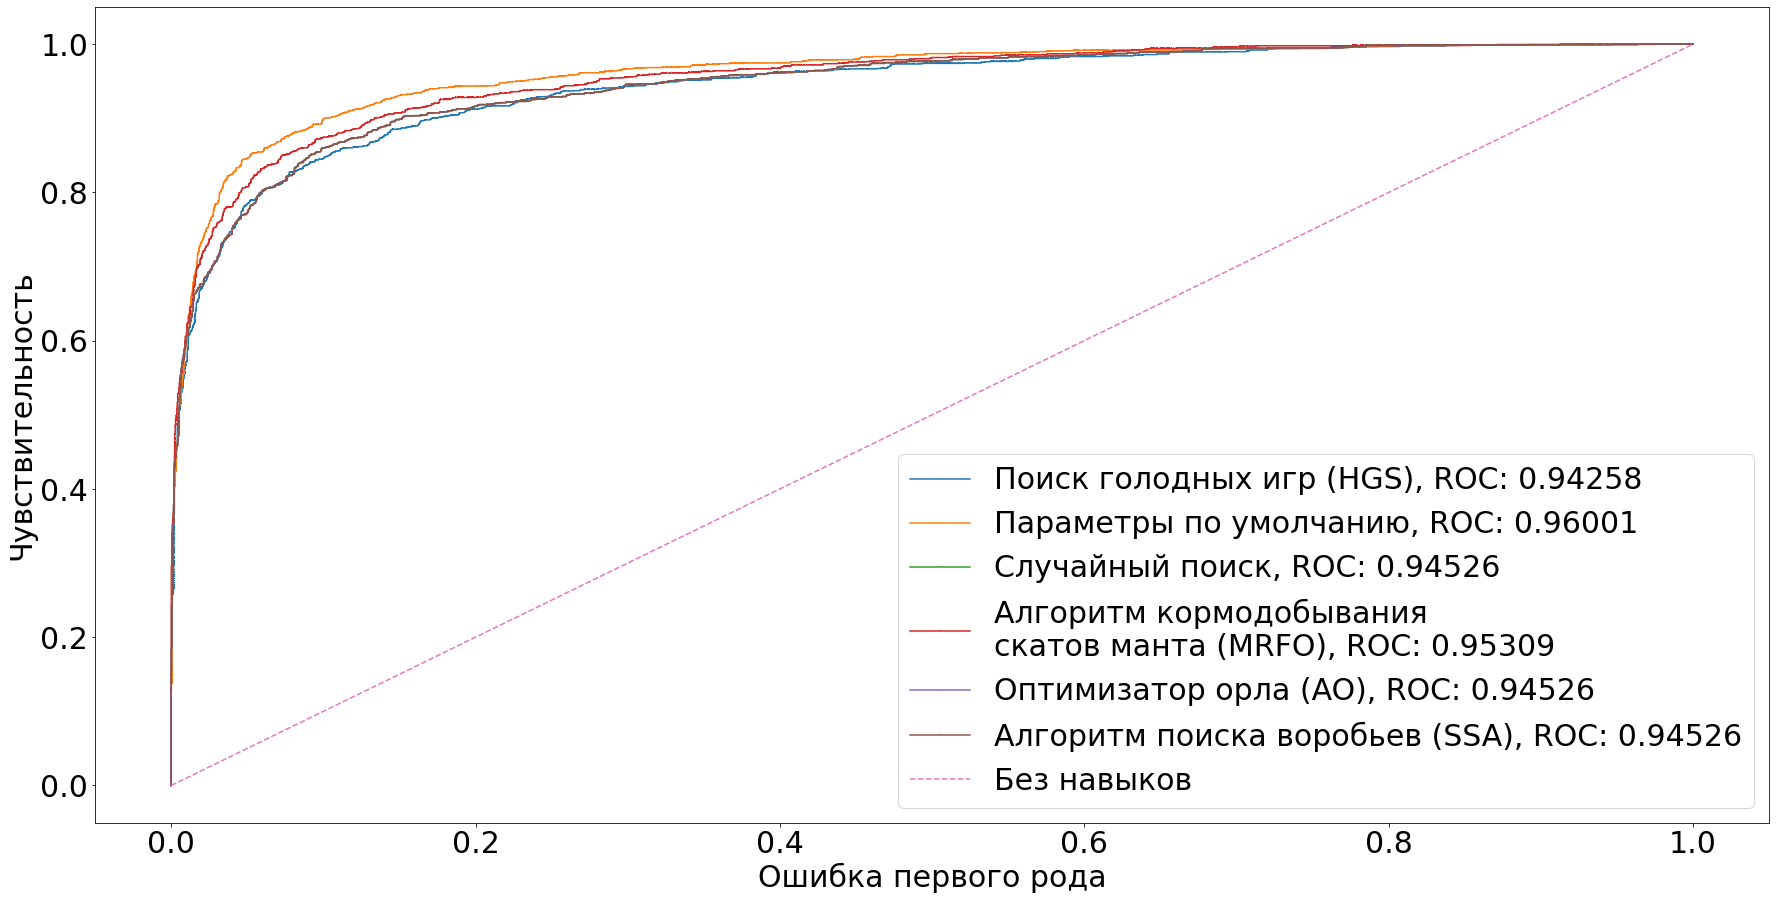

In [129]:

# EN_SA = {1.: 1, 0.: 120}

EN_SA_clfs = {
    "HGS": create_clf(best_EN_HGS, EN_SA),
    "DEFAULT": create_clf(DEFAULT_PARAMS, EN_SA),
    "RSCV": create_clf(best_EN_RSCV, EN_SA),
    "MRFO": create_clf(best_EN_MRFO, EN_SA),
    "AO": create_clf(best_EN_AO, EN_SA),
    "SSA": create_clf(best_EN_SSA, EN_SA)
}

for alg in EN_SA_clfs:
    EN_SA_clfs[alg].fit(X_EN, y_EN)

test(EN_SA_clfs, "EN", "SA")

In [135]:
X, y = X_EN, y_EN

EN_clfs = {
    "RSCV": create_clf(best_EN_RSCV),
    "DEFAULT": create_clf(DEFAULT_PARAMS),
    "MRFO": create_clf(best_EN_MRFO),
    "HGS": create_clf(best_EN_HGS),
    "AO": create_clf(best_EN_AO),
    "SSA": create_clf(best_EN_SSA)
}

for alg in EN_clfs:
    print(alg, mean(cross_val_score(
        EN_clfs[alg], X, y, cv=10, scoring='accuracy')))

RSCV 0.9857627580581422
DEFAULT 0.9858220964313226
MRFO 0.985792449238199
HGS 0.985851743624446
AO 0.9857627580581422
SSA 0.9857627580581422
